This book demonstrates the use of Signature methods (via the iisignature library) to enhance the Least Squares Monte Carlo (LSMC) approach for pricing American-style options.
The project bridges mathematical finance and machine learning by applying path signatures to capture the evolution of stock prices over time.

Unlike European options, which can only be exercised at maturity, American options allow exercise at any point before expiration.
This flexibility introduces significant complexity in valuation, since the holder must determine the optimal exercise strategy — whether to exercise immediately or to continue holding the option.

Traditional analytical methods such as Black-Scholes are not suitable for American options, as they assume a single exercise time.
Therefore, simulation-based methods like LSMC are often employed to approximate the optimal early-exercise policy.



Notations:
- `S0`: Current stock price  
- `K`: Strike price  
- `r`: Risk-free interest rate  
- `sigma`: Volatility of the stock  
- `T`: Time to maturity (years)
- `N`: Divide the total time in N steps

In [ ]:
import numpy as np
import iisignature
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
S0, K, r, sigma, T = 100, 100, 0.05, 0.2, 1.0
N, M = 50, 5000
dt = T / N#each small time interval
discount = np.exp(-r * dt)



In [ ]:
!pip install iisignature

Now when we divide the Maturity time in N small time intervals dt, we simulate M possible paths:
1. Each small interval behaves as a european option and at the end of the time interval the stock price can go up or down and we calculate option value for that time interval.
2. Since they now behave as european options we use geomtric brownian motion to calculate the option value

In [ ]:
def simulate_gbm_paths(S0, mu, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M, N + 1))
    paths[:, 0] = S0
    for i in range(1, N + 1):
        z = np.random.randn(M)
        paths[:, i] = paths[:, i - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return paths

paths = simulate_gbm_paths(S0, r, sigma, T, N, M)

In [ ]:
#Amount earned if we exercise put option immediately
def payoff(S):
    return np.maximum(K - S, 0)


Depth-2 iterated integrals basically are double integrals over time and stock price, capturing the trends in how the stock price changes and interacts with its past movements. Each depth 2 iterated integral is summarised with signature vectors(numerical representation of path) used as features in regression.

In [ ]:

depth = 2
sig_dim = iisignature.siglength(2, depth)

def get_signatures_up_to(paths, t):
    M = paths.shape[0]
    time_grid = np.linspace(0, t * dt, t + 1)
    X = np.zeros((M, sig_dim))
    for i in range(M):
        path_2d = np.column_stack([time_grid, paths[i, :t + 1]])
        X[i] = iisignature.sig(path_2d, depth)
    return X


Backward intuition:


We start at the time of maturity, where the option’s value equals its payoff, because no future decisions remain.
We then move backward in time, one step at a time, asking at each step: should we exercise the option now or hold it?
For each path, we compute the immediate exercise value (payoff if exercised) and the continuation value (expected discounted value if held).
The optimal decision is to take the maximum of these two values.
Once we update the value for the current step, we discount it and treat it as the future value for the previous step.
Repeating this process backward allows us to account for early exercise at every step.
By the time we reach time 0, we have the American option price reflecting the best possible exercise strategy.

Using signatures or other path features in the regression allows us to incorporate the entire history of the path, not just the current stock price, improving the accuracy of the continuation value estimate.

In [ ]:

cashflows = payoff(paths[:, -1])
exercise_times = np.full(M, N)  # to track when each path exercised


for t in range(N - 1, 0, -1):
    # In-the-money paths are calculated since we want to make profit (lol)
    itm = payoff(paths[:, t]) > 0
    if np.sum(itm) == 0:
        continue

    X = get_signatures_up_to(paths[itm], t)
    Y = cashflows[itm] * discount  # discounted future value for the previous step

    # Regress continuation value
    model = LinearRegression().fit(X, Y)
    continuation_values = model.predict(X)

    # Exercise decision
    exercise_values = payoff(paths[itm, t])
    exercise = exercise_values > continuation_values

    # Update cashflows
    exercised_indices = np.where(itm)[0][exercise]
    cashflows[exercised_indices] = exercise_values[exercise]
    exercise_times[exercised_indices] = t
    cashflows *= discount  # discount for next step


In [ ]:
price_estimate = np.mean(cashflows)
print(f"Estimated American put price: {price_estimate:.4f}")


Estimated American put price: 6.0607


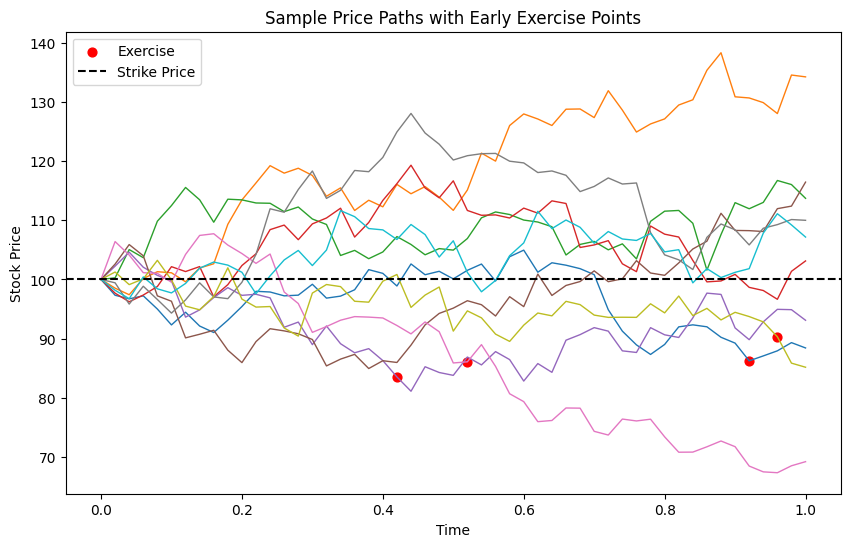

In [ ]:
np.random.seed(1)
num_to_plot = 10
indices = np.random.choice(M, num_to_plot, replace=False)
time_grid = np.linspace(0, T, N + 1)

plt.figure(figsize=(10, 6))
for i in indices:
    plt.plot(time_grid, paths[i], lw=1)
    ex_time = exercise_times[i]
    if ex_time < N:
        plt.scatter(time_grid[ex_time], paths[i, ex_time],
                    color='red', marker='o', s=40, label='Exercise' if i == indices[0] else "")
plt.axhline(K, color='black', ls='--', label='Strike Price')
plt.title("Sample Price Paths with Early Exercise Points")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
